# Interpreting Neural Network Weights

Neural nets (especially deep neural nets) are some of the most powerful machine learning algorithms available.  However, it can be difficult to understand (intuitively) how they work.  

In the first part of this notebook, I highlight the connection between neural networks and template matching--a simple technique for classification that is popular in computer vision and signal processing.  I find this observation is helpful for intution about how neural nets classify images--I hope you find this useful too!

In the second part of the notebook, I point out that for convolutional neural nets it can be helpful to think of weights as sliding filters (e.g. edge detecting filters) which in the early network layers detect low-level image features .

## Template Matching

[Template matching](https://en.wikipedia.org/wiki/Template_matching) is used in computer vision to compare images.  It does this by treating images as vectors and computing their dot product: very similar images give a large dot product, and very disimilar images give a small (or negative) dot product.  Why?

Mathematically, if you represent images as vectors, you can compute the difference between two images $I_1$ and $I_2$ like  
$$|I_1 - I_2 |^2 = |I_1|^2 + |I_2|^2 - 2 \, I_1 \cdot I_2$$  
Note that the dot product $I_1 \cdot I_2$ between two images is largest when the difference $|I_1 - I_2|$ between images is smallest, and vice versa.  

For example, here's a template for each digit:

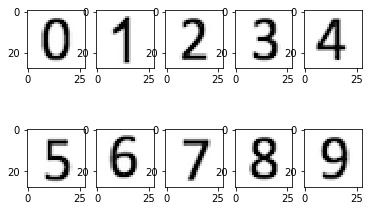

In [1]:
import matplotlib.pyplot as plt
import cv2

templates = []

for i in range(10):
  img = cv2.imread("templates/{}.png".format(str(i)), cv2.IMREAD_GRAYSCALE)
  if img is None:
    raise Exception("Error: Failed to load image {}".format(i))
    
  templates.append(img)
  
  plt.subplot(2, 5, 1 + i)
  plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show() 


We can illustrate template matching by computing the dot products between digit 1 and every other digit.  To make the results more robust, we compute the normalized dot product  
$$ \frac{I_1 \cdot I_2}{|I_1| |I_2|}$$
(It's important to normalize the dot product--otherwise brighter images will give stronger matches than darker ones, and that would not make sense.)  

In [2]:
img = templates[1]

for i in range(10):
  template = templates[i]
  print(" Normalized dot product between 1 and {} = {}".format(i, 
    cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED )[0][0] ))

 Normalized dot product between 1 and 0 = 0.9185173511505127
 Normalized dot product between 1 and 1 = 1.0
 Normalized dot product between 1 and 2 = 0.9375543594360352
 Normalized dot product between 1 and 3 = 0.9283716678619385
 Normalized dot product between 1 and 4 = 0.9515999555587769
 Normalized dot product between 1 and 5 = 0.9398891925811768
 Normalized dot product between 1 and 6 = 0.9233077168464661
 Normalized dot product between 1 and 7 = 0.9516004323959351
 Normalized dot product between 1 and 8 = 0.918259859085083
 Normalized dot product between 1 and 9 = 0.9280534386634827


We can see that 1 is more strongly correlated to 1 than any other digit.  That's the principle behind template matching--it can measure image similarity.  

Unfortunately, template matching is not robust to changes in image shapes, sizes,  rotations, or partial occlusion.  However, neural nets can be very robust to such image defects--that's why they are more powerful.

## Viewing Neural Network Weights as Templates

In a neuron inside neural net, inputs $x$ (a vector) are combined with weights $W$ (another vector) to generate an output.  Pictorally

<img src="figs/neuron.png" style="width: 250px;">

The output of the neuron is computed by  
$$ f( W \cdot x + b) $$  
where $f$ is called the *activation function* and b is called the *bias term*. Most important for this discussion, the dot product $W \cdot x$ resembles template matching.

As we will show, in very simple neural nets (sometimes called *linear classifiers*) we can interpret the weights $W$ as templates--the neural net learns how to perform template matching!

We want to make a linear classifier to recognize digits 0-9.  We implement a softmax architecture (shown below) with 10 outputs.  For example, if digit 7 is recognized, neuron 7 will have an output close to 1 and the remaining neurons will have outputs close to 0.  (FYI, this means we will have to one-hot encode the labels before training.)
The input (the image) is $x$, which we draw as a flattened (1d) vector.  There are 10 weight vectors $W_0$ - $W_9$ (one for each neuron).

<img src="figs/nnet.png" style="width: 400px;"> 

We write the $i^{\mathrm th}$ output as  
$$ \mathrm{output}_i =  f( W_{i} \cdot x + b_i)$$

As we said, we expect each weight vector $W_i$ learned during training will be a template for digit $i$.

Let's train the neural net on the MNIST data set (a set of 70,000 images of hand-written digits 0-9.)  We'll use Keras to implement and train the neural net.

Using TensorFlow backend.


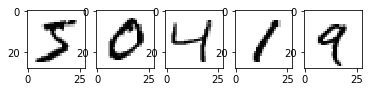

In [3]:
#Developed with Keras 2.0.2 and the tensorflow backend

#Load the MNIST data set of handwritten digits 0-9:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Invert the image colors, convert to float, and normalize values:
x_train = (255 - x_train).astype('float')/255.0
x_test  = (255 - x_test).astype('float')/255.0

# plot first 5 images
for i in range(5):
  plt.subplot(1, 5, 1+i)
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

#Let's flatten the images to 1-d vectors for processing
image_shape = (28, 28)
num_pixels = 28*28
x_train = x_train.reshape(x_train.shape[0], num_pixels)
x_test = x_test.reshape(x_test.shape[0], num_pixels)

In [4]:
#Now let's one-hot encode the target variable before training
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

We can see that after 1-hot encoding, each digit label becomes a 10-d vector.  For example, for the digit 1, there is a 1 in position 1 and 0's in all other positions of the 10-d vector:

In [5]:
y_train[3]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Now let us create the neural net and train it

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.utils import plot_model

# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

# Define the model:
def linear_classifier_model():
  """single layer, 10 output classes"""
  
  # create model
  model = Sequential()

  # one layer
  model.add(Dense(num_classes, kernel_initializer='normal', 
    activation='softmax', input_shape=(num_pixels,)))
  
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

#Instantiate model
model = linear_classifier_model()

#Train model
model.fit(x_train, y_train, validation_data=(x_test, y_test), 
  epochs=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
0s - loss: 0.9814 - acc: 0.7481 - val_loss: 0.5346 - val_acc: 0.8691
Epoch 2/10
0s - loss: 0.4943 - acc: 0.8691 - val_loss: 0.4239 - val_acc: 0.8866
Epoch 3/10
0s - loss: 0.4164 - acc: 0.8853 - val_loss: 0.3817 - val_acc: 0.8924
Epoch 4/10
0s - loss: 0.3813 - acc: 0.8916 - val_loss: 0.3460 - val_acc: 0.9043
Epoch 5/10
0s - loss: 0.3629 - acc: 0.8967 - val_loss: 0.3361 - val_acc: 0.9082
Epoch 6/10
0s - loss: 0.3478 - acc: 0.9011 - val_loss: 0.3314 - val_acc: 0.9052
Epoch 7/10
0s - loss: 0.3368 - acc: 0.9047 - val_loss: 0.3275 - val_acc: 0.9058
Epoch 8/10
0s - loss: 0.3298 - acc: 0.9051 - val_loss: 0.3099 - val_acc: 0.9114
Epoch 9/10
0s - loss: 0.3245 - acc: 0.9074 - val_loss: 0.3121 - val_acc: 0.9087
Epoch 10/10
0s - loss: 0.3197 - acc: 0.9085 - val_loss: 0.3036 - val_acc: 0.9145
Baseline Error: 8.55%


Keras lets us easily visualize the model to check that it has the correct architecture

In [7]:
plot_model(model, to_file='figs/model.png', show_shapes=True)

<img src="figs/model.png">

Finally, let us grab the weights from layer dense_1, unflatten the shape, and graph them:

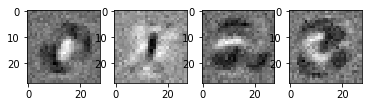

In [8]:
layer_dense_1 = model.get_layer('dense_1')

weights1 = layer_dense_1.get_weights()[0]
bias1 = layer_dense_1.get_weights()[1]

#Cast shape to 2d
weights1 = weights1.reshape(28, 28, 10)

#lot the weights for the first 4 digits
for i in range(4):
  plt.subplot(1, 4, 1 + i)
  plt.imshow(weights1[:, :, i], cmap=plt.get_cmap('gray'))
plt.show()

We can see that indeed the learned weights resember digits 0, 1, 2, 3, ... just as we expected of template matching.  

For further details, take a look at [http://cs231n.github.io/linear-classify/](http://cs231n.github.io/linear-classify/)

## Filters in Convolutional Neural Nets

In convolutional neural networks, it is common to use small (3x3 or 5x5) sliding convolutional layers instead of large, fully-connected layers.  In that case, it may be more helpful to think of the weights as sliding filters to detect low-level features such as edges, textures, and blobs.  Indeed, the learned weights often resemble standard image processing filters.  Let us try to see this.

First, let us reshape (unflatten) the data so the images are again rectangular:

In [9]:
from keras import backend as K
K.set_image_data_format('channels_last')   #specify image format

img_shape = (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

Now let us define the neural net:

In [10]:
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

def covnet_model():
  """Convolutional neural net"""
  model = Sequential()
  
  model.add(Convolution2D(32, kernel_size = 7, strides=1, padding='valid', 
    input_shape=(28, 28, 1), activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.2))
  
  #flatten 3d tensors into 1d vector.  
  model.add(Flatten())
  
  #Add 128 neuron feed forward hidden layer
  model.add(Dense(128, activation='relu'))
  
  #Add output, 10 neurons for 10 target classes, activation is softmax so outputs are 
  #probabilities
  model.add(Dense(num_classes, activation='softmax'))
  
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model_covnet = covnet_model()

Let us plot the network architecture

In [11]:
plot_model(model_covnet, to_file='figs/model2.png', show_shapes=True)

<img src="figs/model2.png" style="width: 350px;">

Now let us train the network

In [12]:
model_covnet.fit(x_train, y_train, validation_data=(x_test, y_test), 
  epochs=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model_covnet.evaluate(x_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
33s - loss: 0.3017 - acc: 0.9151 - val_loss: 0.0875 - val_acc: 0.9747
Epoch 2/10
33s - loss: 0.0822 - acc: 0.9762 - val_loss: 0.0568 - val_acc: 0.9818
Epoch 3/10
33s - loss: 0.0572 - acc: 0.9827 - val_loss: 0.0497 - val_acc: 0.9840
Epoch 4/10
32s - loss: 0.0451 - acc: 0.9862 - val_loss: 0.0354 - val_acc: 0.9883
Epoch 5/10
31s - loss: 0.0391 - acc: 0.9880 - val_loss: 0.0348 - val_acc: 0.9883
Epoch 6/10
30s - loss: 0.0327 - acc: 0.9896 - val_loss: 0.0317 - val_acc: 0.9890
Epoch 7/10
30s - loss: 0.0284 - acc: 0.9909 - val_loss: 0.0304 - val_acc: 0.9901
Epoch 8/10
30s - loss: 0.0235 - acc: 0.9923 - val_loss: 0.0339 - val_acc: 0.9888
Epoch 9/10
30s - loss: 0.0195 - acc: 0.9938 - val_loss: 0.0371 - val_acc: 0.9887
Epoch 10/10
29s - loss: 0.0170 - acc: 0.9945 - val_loss: 0.0306 - val_acc: 0.9902
Baseline Error: 0.98%


Let us now plot 16 convolutional weights (16 filters) learned in the first convolutional layer:

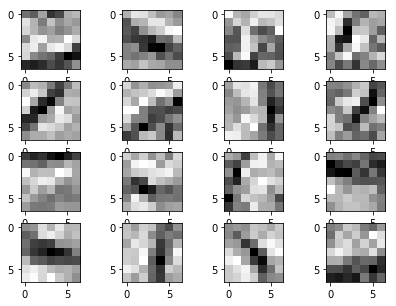

In [13]:
layer_conv2d_4 = model_covnet.get_layer('conv2d_1')

weights2 = layer_conv2d_4.get_weights()[0]
bias2 = layer_conv2d_4.get_weights()[1]

#Cast shape to 2d
weights2 = weights2.reshape(7, 7, 32)

#Now plot the weights for the first 16 filters
plt.figure(figsize=(7,5))
for i in range(16):
  plt.subplot(4, 4, 1 + i)
  plt.imshow(weights2[:, :, i], cmap=plt.get_cmap('gray'))
plt.show()

For comparison, let's plot Sobel filters which are used in computer vision to detect horizontal and vertical edges.  We see that the neural net weights look similar to Sobel filters.

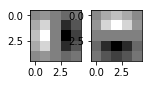

In [14]:
sobelx = np.array([[1, 2,  0, -2, -1], 
                   [4, 8,  0, -8, -4],
                   [6, 12, 0, -12, -6],
                   [4, 8,  0, -8, -4],
                   [1, 2,  0, -2, -1]]).astype('float32')/12.0

sobely = sobelx.transpose()

plt.figure(figsize=(2, 2))
plt.subplot(1, 2, 1)
plt.imshow(sobelx, cmap=plt.get_cmap('gray'))
plt.subplot(1, 2, 2)
plt.imshow(sobely, cmap=plt.get_cmap('gray'))
plt.show()